In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
%matplotlib inline
sns.set()

Скачаем текст войны и мир. Очистите его, оставив только русские буквы и символы пробела

In [2]:
with open('tom_1.txt', 'r') as f:
    text = f.read().lower()
text = re.sub('[^а-я]','', text)

In [3]:
# Формируем словарь
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя'
POS = {l: i for i, l in enumerate(RUSSIAN)}

In [4]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [5]:
# Сколько раз у нас появилось одно и то же событие
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [6]:
# Берем частоту буквы и делим на сумму частот по строчкам (получили вероятность перехода из одного символа в другой)
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [7]:
df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

Построим матрицу переходных вероятностей

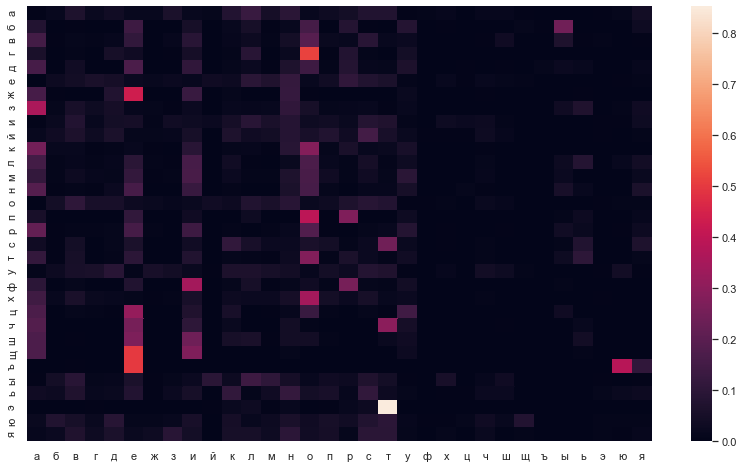

In [8]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

Посчитаем вероятность встретить строку из 4-х символов, которая начинается на п, а кончается на р

In [9]:
start = POS['п']
end = POS['р']
prior = 1. / len(RUSSIAN)
for cp in RUSSIAN:
    for cn in RUSSIAN:
        proba = prior * probabilities[start, POS[cp]] * probabilities[POS[cp], POS[cn]] * probabilities[POS[cn], end]
        if proba > 0:
            print(''.join(['п', cp, cn, 'р']), proba)

паар 3.4239036516768477e-07
пабр 2.604626752045215e-06
павр 2.0199179604239483e-06
пагр 2.6893464662191867e-06
падр 5.261363848047914e-06
паер 3.2849846401501667e-06
пазр 1.3799061412727756e-06
паир 6.774264024671444e-07
пайр 6.516398455063341e-07
пакр 7.742415316635625e-06
палр 1.5329293720462014e-06
памр 6.96477216449837e-07
панр 4.0295676542724513e-07
паор 2.033052324953671e-06
папр 1.4817292962361597e-05
парр 1.5148158822667006e-07
паср 1.189782112544552e-06
патр 7.714275960661948e-06
паур 3.250925002248853e-07
пафр 3.6740925456868023e-06
пахр 6.534261496853781e-07
пацр 4.328072539495433e-09
пачр 6.337058750882866e-08
пашр 1.4984002436813787e-08
пащр 7.3918655589605286e-09
паэр 1.3594046938465655e-07
паюр 6.827290695530214e-07
паяр 9.313323719964372e-07
пбар 7.963116773522978e-09
пббр 3.80809227174425e-10
пбвр 1.3533295360681794e-10
пбгр 2.2875700995014183e-10
пбдр 2.1584189736014788e-10
пбер 3.3218677746037484e-08
пбзр 6.47887755727818e-12
пбир 2.5566134322120978e-09
пбкр 2.360012

In [10]:
proba

9.791744758789872e-08

Используя матрицу переходных вероятностей, сгенерируем слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов

In [11]:
s = []
start = RUSSIAN[1]
s.append(start)
length = 8
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

быебуразн


Выберем ряд и оценим его через HMM. "Построим" (через среднее каждой компоненты) наивный прогноз ряда.

In [12]:
# Загрузка временного ряда
series = pd.read_csv('mean-monthly-air-temperature-deg.csv').dropna().values[:, 1]
series

array([40.6, 40.8, 44.4, 46.7, 54.1, 58.5, 57.7, 56.4, 54.3, 50.5, 42.9,
       39.8, 44.2, 39.8, 45.1, 47.0, 54.1, 58.7, 66.3, 59.9, 57.0, 54.2,
       39.7, 42.8, 37.5, 38.7, 39.5, 42.1, 55.7, 57.8, 56.8, 54.3, 54.3,
       47.1, 41.8, 41.7, 41.8, 40.1, 42.9, 45.8, 49.2, 52.7, 64.2, 59.6,
       54.4, 49.2, 36.6, 37.6, 39.3, 37.5, 38.3, 45.5, 53.2, 57.7, 60.8,
       58.2, 56.4, 49.8, 44.4, 43.6, 40.0, 40.5, 40.8, 45.1, 53.8, 59.4,
       63.5, 61.0, 53.0, 50.0, 38.1, 36.3, 39.2, 43.4, 43.4, 48.9, 50.6,
       56.8, 62.5, 62.0, 57.5, 46.7, 41.6, 39.8, 39.4, 38.5, 45.3, 47.1,
       51.7, 55.0, 60.4, 60.5, 54.7, 50.3, 42.3, 35.2, 40.8, 41.1, 42.8,
       47.3, 50.9, 56.4, 62.2, 60.5, 55.4, 50.2, 43.0, 37.3, 34.8, 31.3,
       41.0, 43.9, 53.1, 56.9, 62.5, 60.3, 59.8, 49.2, 42.9, 41.9, 41.6,
       37.1, 41.2, 46.9, 51.2, 60.4, 60.1, 61.6, 57.0, 50.9, 43.0, 38.8,
       37.1, 38.4, 38.4, 46.5, 53.5, 58.4, 60.6, 58.2, 53.8, 46.6, 45.5,
       40.6, 42.4, 38.4, 40.3, 44.6, 50.9, 57.0, 62

In [13]:
# Временной ряд загрузился как dtype = object, переведем значения в тип float
series = series.astype('float')
t = np.arange(0,len(series))
series

array([40.6, 40.8, 44.4, 46.7, 54.1, 58.5, 57.7, 56.4, 54.3, 50.5, 42.9,
       39.8, 44.2, 39.8, 45.1, 47. , 54.1, 58.7, 66.3, 59.9, 57. , 54.2,
       39.7, 42.8, 37.5, 38.7, 39.5, 42.1, 55.7, 57.8, 56.8, 54.3, 54.3,
       47.1, 41.8, 41.7, 41.8, 40.1, 42.9, 45.8, 49.2, 52.7, 64.2, 59.6,
       54.4, 49.2, 36.6, 37.6, 39.3, 37.5, 38.3, 45.5, 53.2, 57.7, 60.8,
       58.2, 56.4, 49.8, 44.4, 43.6, 40. , 40.5, 40.8, 45.1, 53.8, 59.4,
       63.5, 61. , 53. , 50. , 38.1, 36.3, 39.2, 43.4, 43.4, 48.9, 50.6,
       56.8, 62.5, 62. , 57.5, 46.7, 41.6, 39.8, 39.4, 38.5, 45.3, 47.1,
       51.7, 55. , 60.4, 60.5, 54.7, 50.3, 42.3, 35.2, 40.8, 41.1, 42.8,
       47.3, 50.9, 56.4, 62.2, 60.5, 55.4, 50.2, 43. , 37.3, 34.8, 31.3,
       41. , 43.9, 53.1, 56.9, 62.5, 60.3, 59.8, 49.2, 42.9, 41.9, 41.6,
       37.1, 41.2, 46.9, 51.2, 60.4, 60.1, 61.6, 57. , 50.9, 43. , 38.8,
       37.1, 38.4, 38.4, 46.5, 53.5, 58.4, 60.6, 58.2, 53.8, 46.6, 45.5,
       40.6, 42.4, 38.4, 40.3, 44.6, 50.9, 57. , 62

Text(0.5, 1.0, 'Mean monthly air temperature, deg')

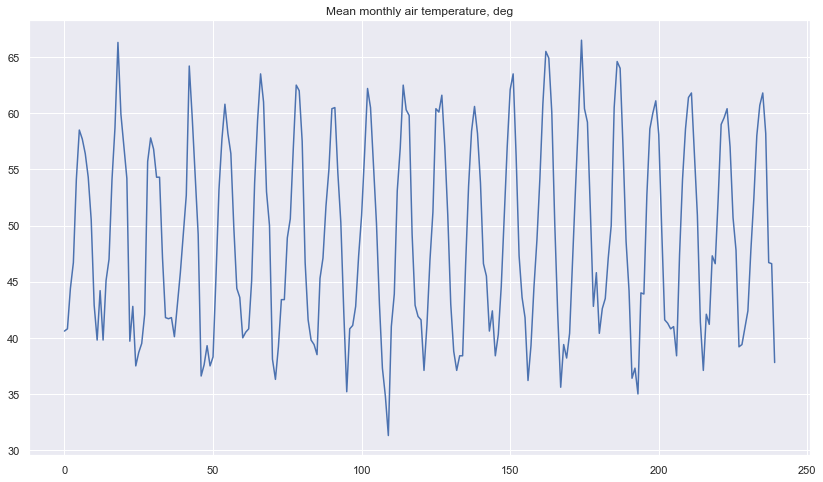

In [14]:
# Строим график временного ряда
plt.style.context('bmh')
plt.figure(figsize=(14, 8))
plt.plot(series)
plt.title('Mean monthly air temperature, deg')

In [15]:
# Оценим ряд через HMM
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.means_ = np.array([[58.0, 60.0], [40.0, 40.0]])

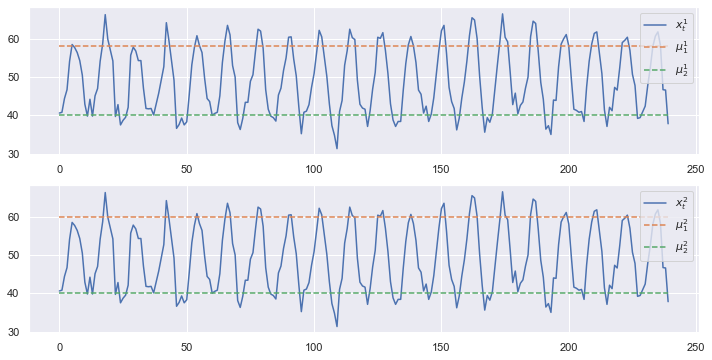

In [16]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
_ = axs[0].plot(series, label='$x^1_t$')
for i in range(2):
    _ = axs[0].plot(range(len(series)), model.means_[i, 0] * np.ones(len(series)), '--', label='$\mu^1_{}$'.format(i+1))
_ = axs[0].legend()

_ = axs[1].plot(series, label='$x^2_t$')
for i in range(2):
    _ = axs[1].plot(range(len(series)), model.means_[i, 1] * np.ones(len(series)), '--', label='$\mu^2_{}$'.format(i+1))
_ = axs[1].legend()

In [17]:
series = series.reshape(-1,1)

In [18]:
# Построим наивный прогноз ряда
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(series)
    print (n, model.score(series))

1 -855.6201905961935
2 -767.9220576513221
3 -729.7130998068983
4 -698.36530540786
5 -659.627341675331
6 -662.2194286353483
7 -623.3203072519049
8 -602.2729421658217
9 -595.1262470712359
10 -575.399466665562
11 -567.5069641322698
12 -569.6634925020885
13 -555.3262768801098


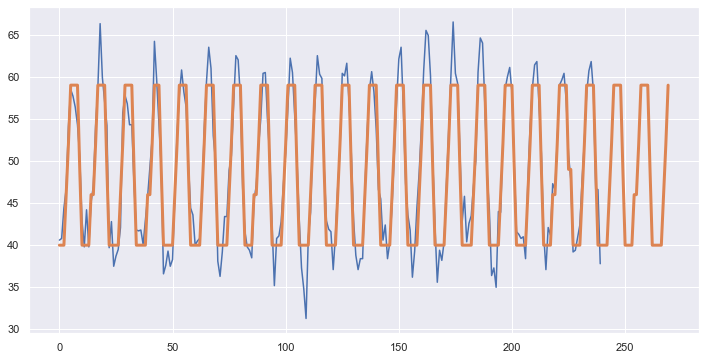

In [19]:
# Построим прогноз на 30 шагов вперед
model = GaussianHMM(n_components=5,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(series)
labels = model.predict(series)
pred = model.predict(series,30)
full = np.hstack([labels,pred])
means = np.zeros_like(full)
for i in range(model.n_components):
    means[full == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(series)
plt.plot(means, linewidth=3)

In [20]:
model.transmat_.shape

(5, 5)

<AxesSubplot:>

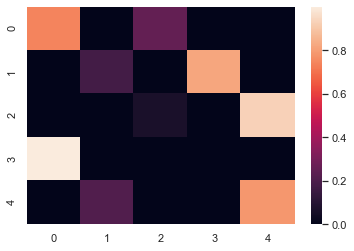

In [21]:
sns.heatmap(model.transmat_)